<a href="https://colab.research.google.com/github/stivenbg/PINNS/blob/main/Deepoonets_biais_aware_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import scipy.io as io
import os
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
import matplotlib.gridspec as gridspec
import torch.nn.init as init


In [2]:
sys.path.insert(0, 'Utilities/')
import os

# from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

np.random.seed(42)
import sys
import torch.nn as nn
import torch.optim as optim

In [4]:
data2 = io.loadmat('/content/train_501_mu2_pod1')
datatest = io.loadmat('/content/test_501_mu2_pod1_v2.mat')

In [7]:
#Data
# %% ici le train cest le test, normalement ca devrait bien fonctionner ensutie je change le test
#u_train, v_train, x_train, y_train, u_test, v_test = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain'], data2['utest'].T, data2['vtest'].T
u_train, v_train, x_train, y_train = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain']

# %%
#u_train = np.reshape(u_train, (101, 40))
#u_train.shape
# %%
#v_train = v_train * 5
v_train.shape
# %%
x_train.shape
# %%
y_train.shape
# %%
x_y_train = np.hstack([x_train, y_train])
# %%
x_y_train = x_y_train
# %%
x_y_train.shape
# %%
u_test = datatest['utest']
u_test = u_test.T
u_test.shape
#%%
#u_test = u_train
u_test.shape

# %%
#v_test = v_train

v_test = datatest['vtest']
v_test = v_test.T
v_test.shape

# #%% test on non scaled data
# v2 = data2['vtest']
# v2 = v_test.T
# #v_test = v_test * 5
# v2.shape
#%%

#x_test, y_test = x_train, y_train
#%%
#x_test.shape
#y_test.shape

# %%
x_test = datatest['xtest']
x_test.shape
 # %%
y_test = datatest['ytest']
y_test.shape
# %%
x_y_test = np.hstack([x_test, y_test])
x_y_test.shape
#%%
x_y_test.shape

(40, 2)

In [8]:
#modele


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

    # Initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l - 1]
            out_dim = layers[l]
            std = np.sqrt(2.0 / (in_dim + out_dim))
            weight = nn.Parameter(torch.randn(in_dim, out_dim) * std)
            bias = nn.Parameter(torch.randn(1, out_dim) * std)
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            A = torch.tanh(torch.matmul(A, W[i]) + b[i])
        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y

    def fnn_T(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            A = torch.tanh(torch.matmul(A, W[i]) + b[i])
        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y


u_dim = 40

# Output dimension for Branch and Trunk Net
G_dim = 40

# Branch Net
layers_f = [u_dim] + [40] * 2 + [G_dim]

# Trunk dim
x_dim = 2

# Trunk Net
layers_x = [x_dim] + [40] * 2 + [G_dim]

model = DNN()

In [9]:
## introducing the differential equations
def f_net(model, x, v, W_branch, b_branch, W_trunk, b_trunk):
    mu = 2
    epsilon = 0.01

    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

    u_x = torch.autograd.grad(u_pred.sum(), x[:, 0], create_graph=True)
    u_y = torch.autograd.grad(u_pred, x[:, 1])
    u_xx = torch.autograd.grad(u_x, x[:, 0])
    u_yy = torch.autograd.grad(u_y, x[:, 1])

    laplacian = u_xx + u_yy
    res_loss = np.sqrt(1 + (epsilon * mu) ** 2) * laplacian - mu ** 2 * u_pred - mu**2 * v


def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    optimizer.zero_grad()
    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

    mu = 2
    epsilon = 0.01

    inputs = torch.ones(40, 1) # faire attention à cette ligne parce qu'elle definit la dimension de l'input. A chaque fois qu'on change la dimn  de l'input changer la dim ici
    u_1 = u_pred
    #     u_1 = u_1.reshape(-1, 1)
    residual = 0.0
    for i in range(len(u_pred)):
        u1 = u_pred[i, :]
        u1 = u1.T
        u1 = u1.reshape(-1, 1)

        grad_u = torch.autograd.grad(u1, x, grad_outputs=inputs, create_graph=True)[0]
        u_x = grad_u[:, 0].reshape(-1, 1)

        u_y = grad_u[:, 1].reshape(-1, 1)

        grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=inputs, create_graph=True)[0]
        u_xx = grad_u_x[:, 0].reshape(-1, 1)

        grad_u_y = torch.autograd.grad(u_y, x, grad_outputs=inputs, create_graph=True)[0]
        u_yy = grad_u_y[:, 1].reshape(-1, 1)

        v1 = v.T
        v1 = v1[:, i].reshape(-1, 1)

        laplacian = u_xx + u_yy
        res_loss = - np.sqrt(1 + (epsilon * mu) ** 2) * laplacian.reshape(-1, ) - mu ** 2 * u1.reshape(
            -1, ) - v1.reshape(-1, )  ##pde loss ici dans v y'a deja mu donc on eleve mu devant
        residual += res_loss
    #         residual.append(res_loss)

    #     x1 = x[:,0]
    #     x1 = x1.reshape((-1,1))
    #     expanded_x = x1.expand(-1, 100)

    #     y1 = x[:,1]
    #     y1 = y1.reshape((-1,1))
    #     expanded_y = y1.expand(-1, 100)

    #     grad_u_hat = torch.autograd.grad(u_1, expanded_x, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]
    #     u_x = grad_u_hat

    #     u_y = torch.autograd.grad(u_1, expanded_y, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    # #     u_y = grad_u_hat[:, 1].reshape(-1,1)

    #     u_xx = torch.autograd.grad(u_x, expanded_x, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    #     u_yy = torch.autograd.grad(u_y, expanded_y, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    # #     grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=inputs, create_graph=True)[0]
    # #     u_xx = grad_u_x[:, 0].reshape(-1,1)

    # #     grad_u_y = torch.autograd.grad(u_y, x, grad_outputs=inputs, create_graph=True)[0]
    # #     u_yy = grad_u_y[:, 1].reshape(-1,1)

    #     v_1 = v.T
    # #     v_1 = v_1[:, 0].reshape(-1, 1)

    #     laplacian = u_xx+u_yy
    #     res_loss = np.sqrt(1+(epsilon*mu)**2)*laplacian.reshape(-1,)-mu**2*u_1.reshape(-1,)-mu*v_1.reshape(-1,)  ##pde loss

    #     residual = f_net(model, x, v, W_branch, b_branch, W_trunk, b_trunk)

    #     residual = np.array(residual, dtype = np.float32)
    #     residual = residual.reshape(-1,1)
    loss_pde = torch.mean(torch.abs(residual)) #utiliser abs c'est MAE, plutôt que square pour mse
    data_loss = torch.mean(torch.square(u_pred - u))
    #loss = data_loss + 0.00005*loss_pde
    #loss = loss_pde
    loss = data_loss


    loss = torch.mean(torch.square(u_pred - u))
    loss.backward()
    optimizer.step()
    return loss.item(), u_pred.detach(), loss_pde.item(), data_loss.item()


def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    x_test_tensor = torch.from_numpy(x).float()
    v_test_tensor = torch.from_numpy(v).float()
    u_test_tensor = torch.from_numpy(u).float()

    with torch.no_grad():
        u_out_branch = model.fnn_B(v_test_tensor, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x_test_tensor, W_trunk, b_trunk)
        # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
        u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

        loss = torch.mean(torch.square(u_pred - u_test_tensor))

    return loss.item(), u_pred.detach().numpy()

In [10]:
#Initialisation
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk = model.hyper_initial(layers_x)

Iteration: 0 Train_loss:9.233806486008689e-05, Test_loss: 0.0030442061834037304


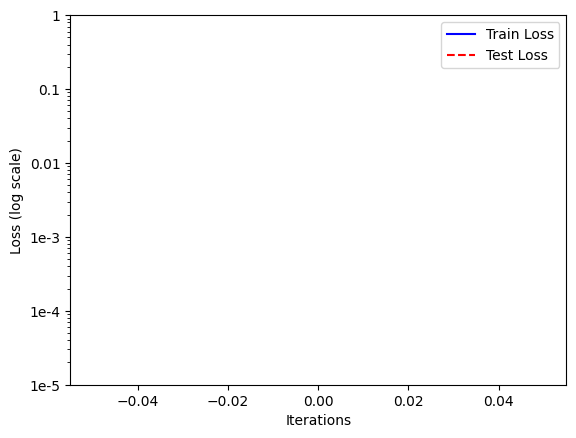

Iteration: 20 Train_loss:0.0008452031761407852, Test_loss: 0.002292972058057785
Iteration: 40 Train_loss:0.0005387673736549914, Test_loss: 0.0017985283629968762
Iteration: 60 Train_loss:0.00030491125653497875, Test_loss: 0.001687553245574236
Iteration: 80 Train_loss:0.00036794794141314924, Test_loss: 0.001774209551513195
Iteration: 100 Train_loss:0.00022095411259215325, Test_loss: 0.0015549329109489918
Iteration: 120 Train_loss:0.00015641014033462852, Test_loss: 0.0015161659102886915
Iteration: 140 Train_loss:0.00015116974827833474, Test_loss: 0.001526161446236074


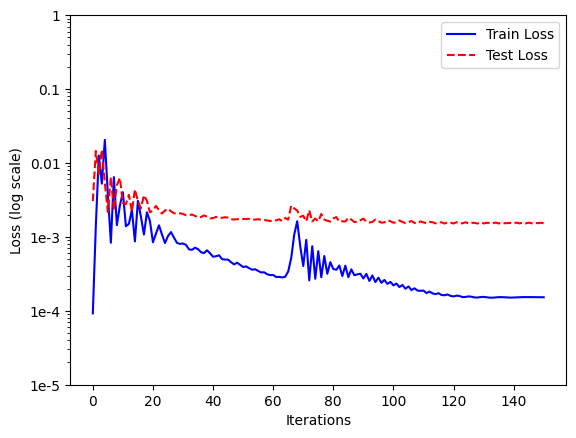

Iteration: 160 Train_loss:0.00022743071895092726, Test_loss: 0.0015194914303719997
Iteration: 180 Train_loss:0.00025641245883889496, Test_loss: 0.001580391894094646
Iteration: 200 Train_loss:0.0001882192154880613, Test_loss: 0.0015243731904774904
Iteration: 220 Train_loss:0.00015344654093496501, Test_loss: 0.0015449348138645291
Iteration: 240 Train_loss:0.000155344809172675, Test_loss: 0.0015215480234473944
Iteration: 260 Train_loss:0.000355459371348843, Test_loss: 0.002242965390905738
Iteration: 280 Train_loss:0.0003108191303908825, Test_loss: 0.0016515713650733232
Iteration: 300 Train_loss:0.00019014069403056055, Test_loss: 0.0015475921100005507


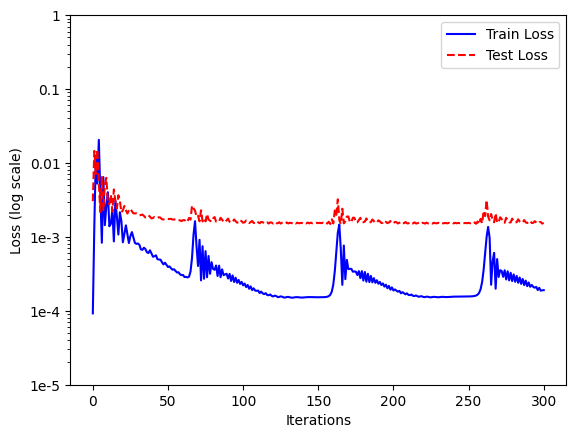

Iteration: 320 Train_loss:0.00016093181329779327, Test_loss: 0.0015584086067974567
Iteration: 340 Train_loss:0.00016167106514330953, Test_loss: 0.0015253223245963454
Iteration: 360 Train_loss:0.00022123187955003232, Test_loss: 0.001765439985319972
Iteration: 380 Train_loss:0.00022427500516641885, Test_loss: 0.001534097595140338
Iteration: 400 Train_loss:0.0001640748232603073, Test_loss: 0.0015091896057128906
Iteration: 420 Train_loss:0.0004281258152332157, Test_loss: 0.002115527866408229
Iteration: 440 Train_loss:0.00021119596203789115, Test_loss: 0.001519000274129212


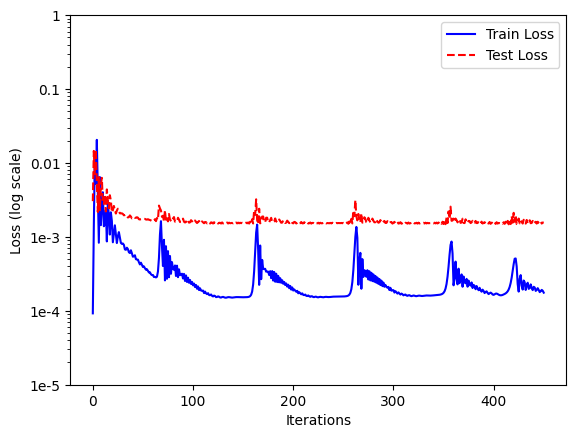

Iteration: 460 Train_loss:0.000171716368640773, Test_loss: 0.0015029478818178177
Iteration: 480 Train_loss:0.00024810206377878785, Test_loss: 0.00155476457439363
Iteration: 500 Train_loss:0.00019940428319387138, Test_loss: 0.0015043901512399316
Iteration: 520 Train_loss:0.00016621986287645996, Test_loss: 0.0015274491161108017
Iteration: 540 Train_loss:0.0004092298331670463, Test_loss: 0.0016242184210568666
Iteration: 560 Train_loss:0.0001949737052200362, Test_loss: 0.0015322668477892876
Iteration: 580 Train_loss:0.0002594545076135546, Test_loss: 0.0018577182199805975
Iteration: 600 Train_loss:0.00032853762968443334, Test_loss: 0.0017252075485885143


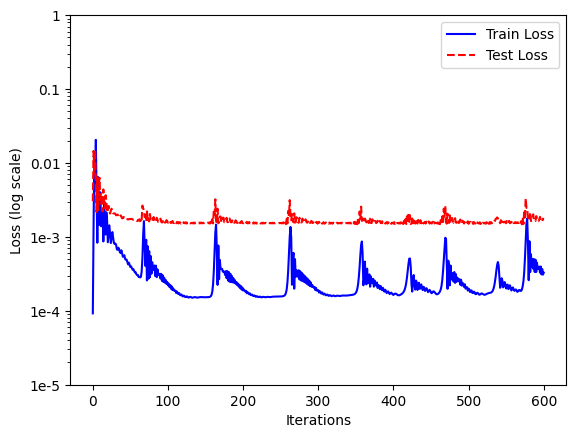

Iteration: 620 Train_loss:0.00017961577395908535, Test_loss: 0.0015065440675243735
Training interrupted. Saving the model...


In [33]:

from torch.optim.lr_scheduler import ReduceLROnPlateau

n = 0
nmax = 1000
lr = 1.4e-2
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
l2_reg_strength = 1e-4  # You can adjust this value

optimizer = optim.Adam(list(W_branch) + list(b_branch) + list(W_trunk) + list(b_trunk), lr=lr,  weight_decay=l2_reg_strength)
scheduler = ReduceLROnPlateau(optimizer=optimizer)

data_loss_list = []
pde_loss_list = []
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

try:
    while n <= nmax:
        x_train_tensor = torch.from_numpy(x_y_train).float()
        x_train_tensor.requires_grad_(True)
        v_train_tensor = torch.from_numpy(v_train).float()
        u_train_tensor = torch.from_numpy(u_train).float()

        loss_train, u_train_pred, pde_train, data_loss = train_step(model, W_branch, b_branch, W_trunk,
                                              b_trunk, v_train_tensor, x_train_tensor, u_train_tensor,
                                              optimizer)
        #     #err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1) /
        #                         np.linalg.norm(u_train, 2, axis=1))

        u_train_pred_np = u_train_pred.detach().numpy()

        err_train = np.mean(np.linalg.norm(u_train - u_train_pred_np, 2, axis=1) /
                            np.linalg.norm(u_train, 2, axis=1))

        loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_y_test, u_test,
                                           optimizer)
        err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1) /
                           np.linalg.norm(u_test, 2, axis=1))

        if n % 20 == 0:
            print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
            #print(f"Iteration: {n} Train_loss:{loss_train}, pde_loss:{pde_train}")

        train_err_list.append(err_train)
        test_err_list.append(err_test)
        train_loss_list.append(loss_train)
        test_loss_list.append(loss_test)
        pde_loss_list.append(pde_train)
        data_loss_list.append(data_loss)

        if n % 150 == 0:
            gs = gridspec.GridSpec(1, 1)
            ax = plt.subplot(gs[:, :])
            plt.semilogy(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            plt.semilogy(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')

            #plt.plot(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            #plt.plot(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            #plt.semilogy(range(len(pde_loss_list)), pde_loss_list, 'g-.', label='PDE_t Loss')
            #plt.semilogy(range(len(data_loss_list)), data_loss_list, 'm:', label='Data_t loss')

            plt.xlabel('Iterations')
            plt.ylabel('Loss (log scale)')

            # Set the y-axis ticks and labels using a logarithmic scale
            yticks = [ 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10 ** 0]
            yticklabels = [ '1e-5', '1e-4', '1e-3', '0.01', '0.1', '1']
            plt.yticks(yticks, yticklabels)
            # Set the y-axis limits
            ax.set_ylim([10 ** -5, 1])

            plt.legend()
            plt.show()


        n = n + 1

except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")

# Save the model
#torch.save(model.state_dict(), 'model_deeponet.pth')

In [32]:
u_test_pred[-1, :]

array([ 0.01559211, -0.01221691, -0.05992101,  0.00703168,  0.02512234,
        0.01264007, -0.00951954, -0.0055464 , -0.00249657,  0.00191519,
       -0.04593698, -0.00468341, -0.02268459,  0.01598892, -0.05342331,
       -0.00293403,  0.00999282,  0.01899476, -0.02321159, -0.00512604,
       -0.00580696,  0.01923436,  0.05697231, -0.01618066,  0.01698001,
        0.00083934,  0.03523774,  0.0607039 , -0.02522023, -0.05332609,
        0.05886846,  0.04018289, -0.00701531, -0.00601098, -0.00086329,
        0.03119786,  0.07636118,  0.023768  ,  0.0031681 ,  0.00738848],
      dtype=float32)